# Regional Influence

Hypothesis: <b>
UFO sightings are more prevalent in countries with higher Netflix usage after the release of alien films.
	


In [10]:
from setup.helper.sql_engine import get_engine
from sqlalchemy import text
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [77]:
# Get the engine
engine = get_engine()

In [78]:
with engine.connect() as connection:
    connection.execute(text("USE ufo_sightings;"))
    result = connection.execute(text("""
        with sightings_per_country as(
        select country_id, count(country_id) as sightings_count
        from ufo_sightings 
        WHERE date LIKE "%2022" -- using 2022 as baseline as last year with complete observations in dataset
        Group by country_id),
        max_sightings AS (
            SELECT MAX(sightings_count / population)*1000 AS max_sightings_per_capita
            from countries c
            JOIN sightings_per_country u USING (country_id)
        )
        select c.country_id, c.country, s.subscribers, c.population, round(s.subscribers/c.population*100,2) as pentration, u.sightings_count,
        sightings_count/population*1000/(select max_sightings_per_capita from max_sightings) as sightings_per_capita_normalised
        from subscribers s
        JOIN countries c
        USING (country_id)
        JOIN sightings_per_country u
        USING (country_id)
        WHERE country_id IN (select DISTINCT country_id FROM ufo_sightings)
        ORDER by sightings_per_capita_normalised DESC;"""))
    df = pd.DataFrame(result.all())
    df["pentration"] = df["pentration"].astype(float)
    df["sightings_per_capita_normalised"] = round(df["sightings_per_capita_normalised"].astype(float),3)

                            OLS Regression Results                            
Dep. Variable:        sightings_count   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.625
Date:                Thu, 27 Mar 2025   Prob (F-statistic):              0.114
Time:                        19:33:39   Log-Likelihood:                -293.63
No. Observations:                  37   AIC:                             591.3
Df Residuals:                      35   BIC:                             594.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -99.0979    182.218     -0.544      0.5

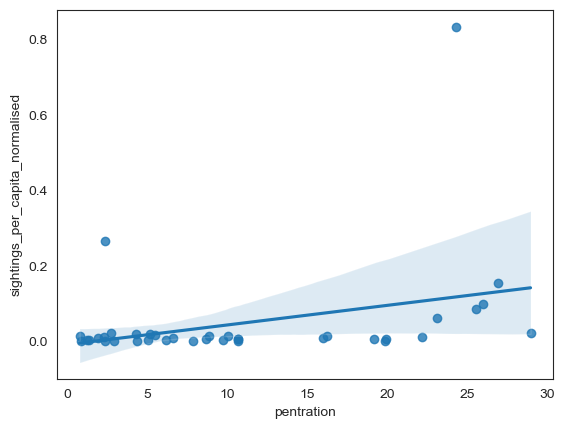

In [83]:
sns.regplot(df, x="pentration", y="sightings_per_capita_normalised")
            
# Add a constant for the intercept
X = sm.add_constant(df["pentration"])

# Fit Model
model = sm.OLS(df["sightings_count"], X).fit()

# Summary
print(model.summary())